In [1]:
# import torch

In [2]:
# model = torch.hub.load('aerial-darknet', 'custom', path='yolo-test/yolov3-aerial.weights', source='local')

In [3]:
import os
import scipy.io
import scipy.misc
import numpy as np
import PIL
import struct
import cv2
from numpy import expand_dims
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D
from keras.models import load_model, Model
from matplotlib import pyplot
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib.patches import Rectangle

2023-03-27 14:06:17.122645: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-27 14:06:17.278249: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-27 14:06:17.278762: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-27 14:06:17.924859: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)

        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
        return self.get_score

def _sigmoid(x):
    return 1. /(1. + np.exp(-x))

def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5
    boxes = []
    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh
 
    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w
        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[int(row)][int(col)][b][4]
            if(objectness.all() <= obj_thresh): continue
            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[int(row)][int(col)][b][:4]
            x = (col + x) / grid_w # center position, unit: image width
            y = (row + y) / grid_h # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
            # last elements are class probabilities
            classes = netout[int(row)][col][b][5:]
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            boxes.append(box)
    return boxes

In [5]:
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    new_w, new_h = net_w, net_h
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

In [25]:
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect = intersect_w * intersect_h
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union
 
def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0: continue
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    # enumerate all boxes
    for box in boxes:
        # enumerate all possible labels
        for i in range(len(labels)):
            # check if the threshold for this label is high enough
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
                # don't break, many labels may trigger for one box
    return v_boxes, v_labels, v_scores

# draw all results
def draw_boxes(image, v_boxes, v_labels, v_scores):
  
#     # load the image
#     data = pyplot.imread(filename)
    # plot the image
    pyplot.imshow(image)
    # get the context for drawing boxes
    ax = pyplot.gca()
    # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='red', linewidth = 1)
        # draw the box
        ax.add_patch(rect)
        # draw text and score in top left corner
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        pyplot.text(x1, y1, label, color='red')
    # show the plot
    pyplot.show()

In [7]:
# anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
anchors = [[10,13, 16,30, 33,23], [30,61, 62,45, 59,119], [116,90, 156,198, 373,326]]

class_threshold = 0.6

labels = ["car", "truck", "bus", "minibus", "cyclist"]

In [8]:
from tensorflow import keras
import cv2
model = keras.models.load_model('/home/matt/RT-Flight/yolo-test/yolov3.h5', compile=False)

In [9]:
from numpy import expand_dims
from keras.utils import load_img
from keras.utils import img_to_array
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size

    # load the image with the required size
    image = load_img(filename, target_size=shape) # convert to numpy array
    image = img_to_array(image)

    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0

    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    return image, width, height

(1, 416, 416, 3)
1/1 [==============================] - 0s 156ms/step
[(1, 13, 13, 75), (1, 26, 26, 75), (1, 52, 52, 75)]
h: 800 w: 800 ih: 416 iw: 416
drawing
7


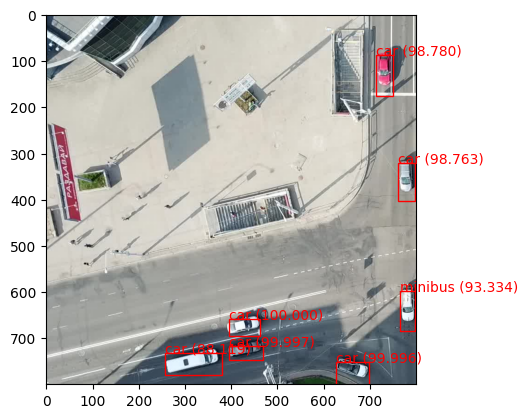

(1, 416, 416, 3)
1/1 [==============================] - 0s 169ms/step
[(1, 13, 13, 75), (1, 26, 26, 75), (1, 52, 52, 75)]
h: 800 w: 800 ih: 416 iw: 416
drawing
11


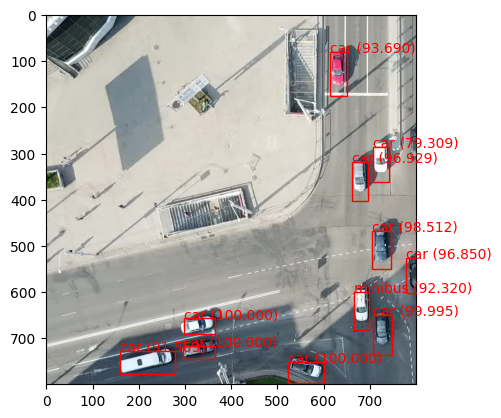

(1, 416, 416, 3)
1/1 [==============================] - 0s 163ms/step
[(1, 13, 13, 75), (1, 26, 26, 75), (1, 52, 52, 75)]
h: 800 w: 800 ih: 416 iw: 416
drawing
13


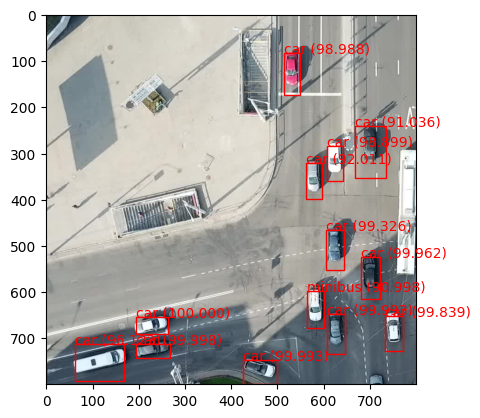

(1, 416, 416, 3)
1/1 [==============================] - 0s 158ms/step
[(1, 13, 13, 75), (1, 26, 26, 75), (1, 52, 52, 75)]
h: 800 w: 800 ih: 416 iw: 416
drawing
5


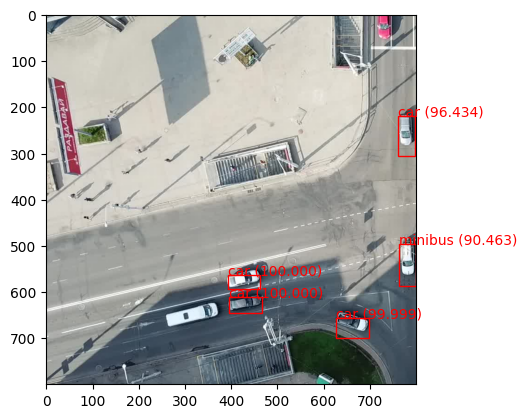

(1, 416, 416, 3)
1/1 [==============================] - 0s 162ms/step
[(1, 13, 13, 75), (1, 26, 26, 75), (1, 52, 52, 75)]
h: 800 w: 800 ih: 416 iw: 416
drawing
10


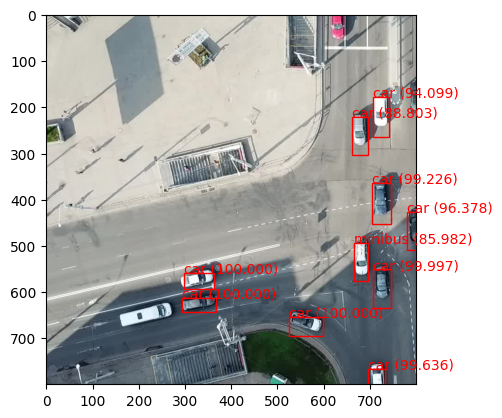

(1, 416, 416, 3)
1/1 [==============================] - 0s 162ms/step
[(1, 13, 13, 75), (1, 26, 26, 75), (1, 52, 52, 75)]
h: 800 w: 800 ih: 416 iw: 416
drawing
15


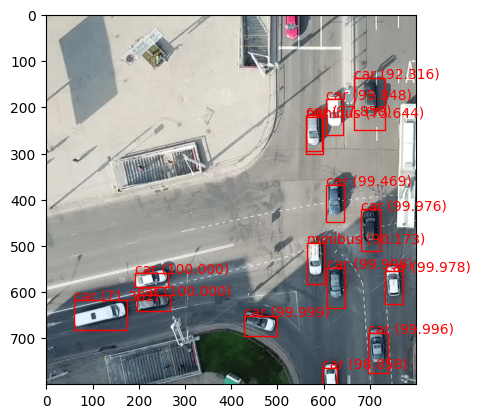

(1, 416, 416, 3)
1/1 [==============================] - 0s 165ms/step
[(1, 13, 13, 75), (1, 26, 26, 75), (1, 52, 52, 75)]
h: 800 w: 800 ih: 416 iw: 416
drawing
6


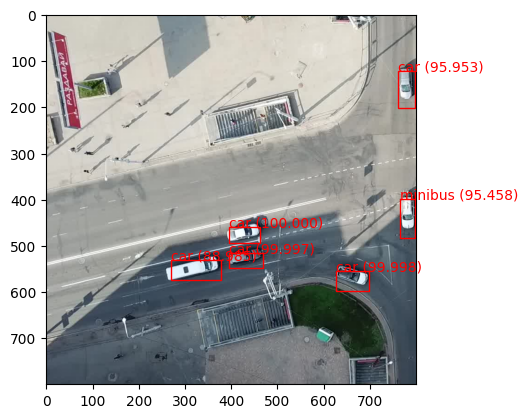

(1, 416, 416, 3)
1/1 [==============================] - 0s 160ms/step
[(1, 13, 13, 75), (1, 26, 26, 75), (1, 52, 52, 75)]
h: 800 w: 800 ih: 416 iw: 416
drawing
11


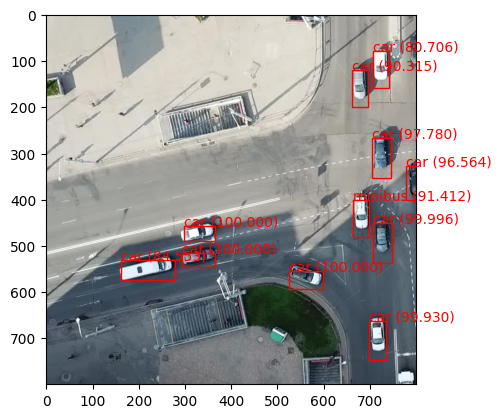

(1, 416, 416, 3)
1/1 [==============================] - 0s 159ms/step
[(1, 13, 13, 75), (1, 26, 26, 75), (1, 52, 52, 75)]
h: 800 w: 800 ih: 416 iw: 416
drawing
14


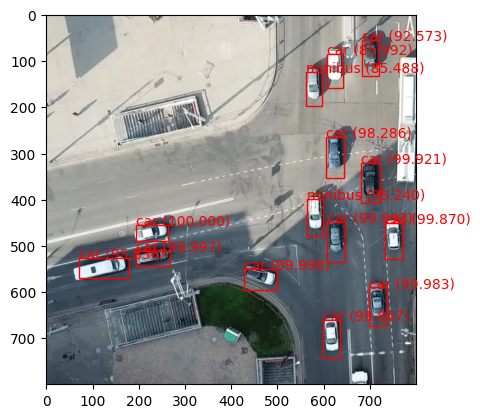

(1, 416, 416, 3)
1/1 [==============================] - 0s 165ms/step
[(1, 13, 13, 75), (1, 26, 26, 75), (1, 52, 52, 75)]
h: 780 w: 800 ih: 416 iw: 416
drawing
6


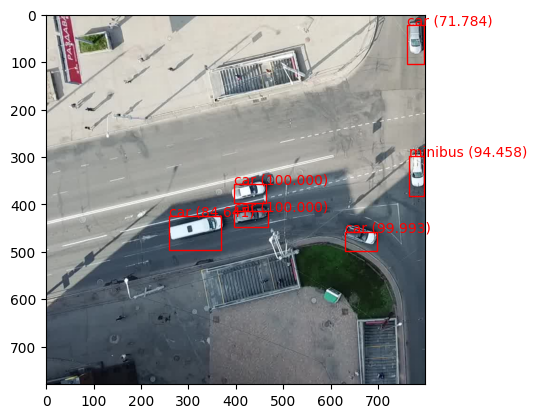

(1, 416, 416, 3)
1/1 [==============================] - 0s 158ms/step
[(1, 13, 13, 75), (1, 26, 26, 75), (1, 52, 52, 75)]
h: 780 w: 800 ih: 416 iw: 416
drawing
11


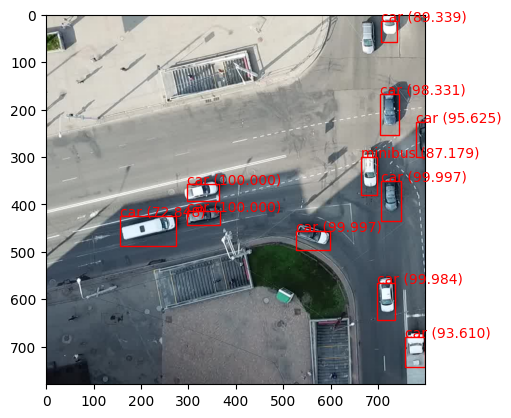

(1, 416, 416, 3)
1/1 [==============================] - 0s 163ms/step
[(1, 13, 13, 75), (1, 26, 26, 75), (1, 52, 52, 75)]
h: 780 w: 800 ih: 416 iw: 416
drawing
15


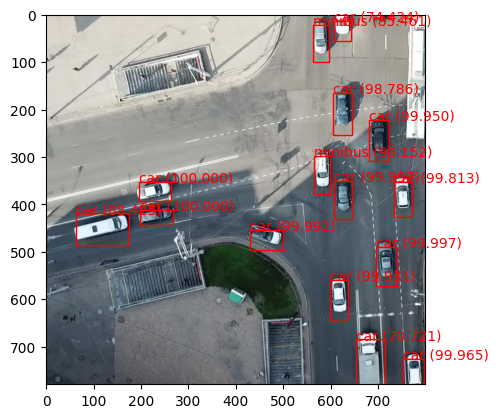

(1, 416, 416, 3)
1/1 [==============================] - 0s 163ms/step
[(1, 13, 13, 75), (1, 26, 26, 75), (1, 52, 52, 75)]
h: 680 w: 800 ih: 416 iw: 416
drawing
5


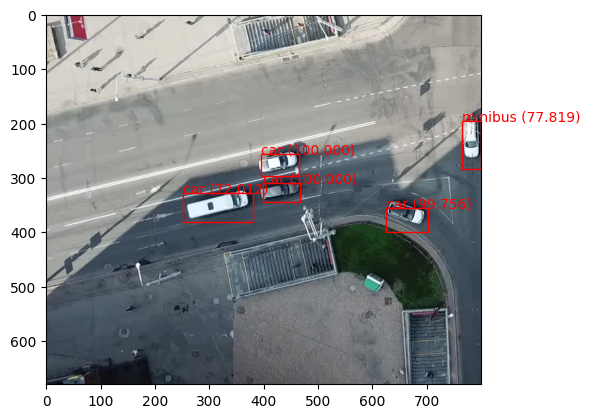

(1, 416, 416, 3)
1/1 [==============================] - 0s 171ms/step
[(1, 13, 13, 75), (1, 26, 26, 75), (1, 52, 52, 75)]
h: 680 w: 800 ih: 416 iw: 416
drawing
10


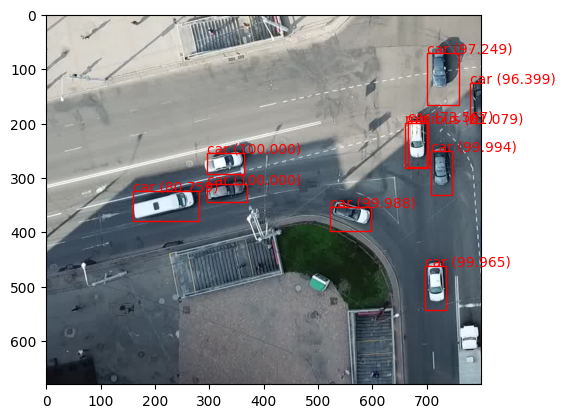

(1, 416, 416, 3)
1/1 [==============================] - 0s 158ms/step
[(1, 13, 13, 75), (1, 26, 26, 75), (1, 52, 52, 75)]
h: 680 w: 800 ih: 416 iw: 416
drawing
13


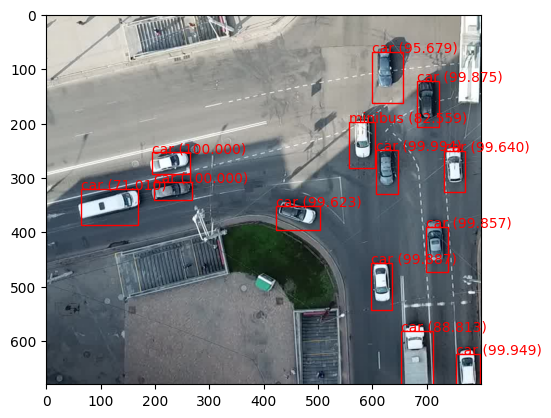

In [44]:
# define the expected input shape for the model
input_w, input_h = 416, 416
# define our new photo
photo_filename = "/home/matt/RT-Flight/yolo-test/test-aerial-image.jpg"

from PIL import Image

im1 = np.asarray(Image.open(photo_filename))

images = []
sample_image_size = 800
step_size = 100
for i in range(5):
    for j in range(3):
        image = im1[step_size*i:step_size*i+sample_image_size, step_size*j:step_size*j+sample_image_size]
        images.append(image)

for sample_image in images:

    image_h = sample_image.shape[0]
    image_w = sample_image.shape[1]
    
    im = Image.fromarray(sample_image)

    im1 = im.resize((416, 416))
    im1 = np.asarray(im1)
    im = im1.astype('float32')
    im /= 255.0
    im = im.reshape(1, 416, 416, 3)
    print(im.shape)

    # make prediction
    yhat = model.predict(im)
    # summarize the shape of the list of arrays
    print([a.shape for a in yhat])
    # define the anchors
    anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
    # define the probability threshold for detected objects
    class_threshold = 0.7
    boxes = list()
    for i in range(len(yhat)):
        # decode the output of the network
        boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
    # correct the sizes of the bounding boxes for the shape of the image
    print(f"h: {image_h} w: {image_w} ih: {input_h} iw: {input_w}")
    correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
    # suppress non-maximal boxes
    do_nms(boxes, 0.4)
    # define the labels
    labels = ["car", "truck", "bus", "minibus", "cyclist"]
    v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
    # summarize what we found
    # for i in range(len(v_boxes)):
    #     print(v_labels[i], v_scores[i])
    # draw what we found
    print("drawing")
    print(len(v_boxes))
    draw_boxes(sample_image, v_boxes, v_labels, v_scores)

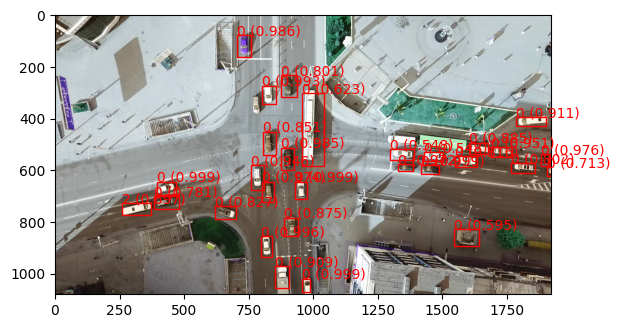

In [25]:
#############################################
# Object detection - YOLO - OpenCV
# Author : Arun Ponnusamy   (July 16, 2018)
# Website : http://www.arunponnusamy.com
############################################


import cv2
import numpy as np


def get_output_layers(net):
    
    layer_names = net.getLayerNames()
    try:
        output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
    except:
        output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    return output_layers


def draw_prediction(img, class_id, confidence, x, y, x_plus_w, y_plus_h):

    label = str(classes[class_id])

    color = COLORS[class_id]

    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)

    cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    
image = cv2.imread("/home/matt/RT-Flight/yolo-test/test-aerial-image.jpg")

Width = image.shape[1]
Height = image.shape[0]
scale = 0.00392

classes = None

classes_file = "/home/matt/RT-Flight/yolo-test/aerial-darknet/data/aerial.names"
with open(classes_file, 'r') as f:
    classes = [line.strip() for line in f.readlines()]

COLORS = np.random.uniform(0, 255, size=(len(classes), 3))

cfg_file = "/home/matt/RT-Flight/yolo-test/aerial-darknet/cfg/yolov3-aerial.cfg"
weights_file = "/home/matt/RT-Flight/yolo-test/yolov3-aerial.weights"
net = cv2.dnn.readNet(weights_file, cfg_file)

blob = cv2.dnn.blobFromImage(image, scale, (416,416), (0,0,0), True, crop=False)

net.setInput(blob)

outs = net.forward(get_output_layers(net))

class_ids = []
confidences = []
boxes = []
conf_threshold = 0.5
nms_threshold = 0.4


for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            center_x = int(detection[0] * Width)
            center_y = int(detection[1] * Height)
            w = int(detection[2] * Width)
            h = int(detection[3] * Height)
            x = center_x - w / 2
            y = center_y - h / 2
            class_ids.append(class_id)
            confidences.append(float(confidence))
            boxes.append([x, y, w, h])


indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)


bound_boxes = []
for i in indices:
    try:
        box = boxes[i]

    except:
        i = i[0]
        box = boxes[i]
        
    
    x = box[0]
    y = box[1]
    w = box[2]
    h = box[3]
    
    bound_box = BoundBox(x, y, x+w, y+h, confidences[i], class_ids[i])
    bound_boxes.append(bound_box)

    
v_boxes = bound_boxes
v_labels = class_ids
v_scores = confidences

draw_boxes(image, v_boxes, v_labels, v_scores)
